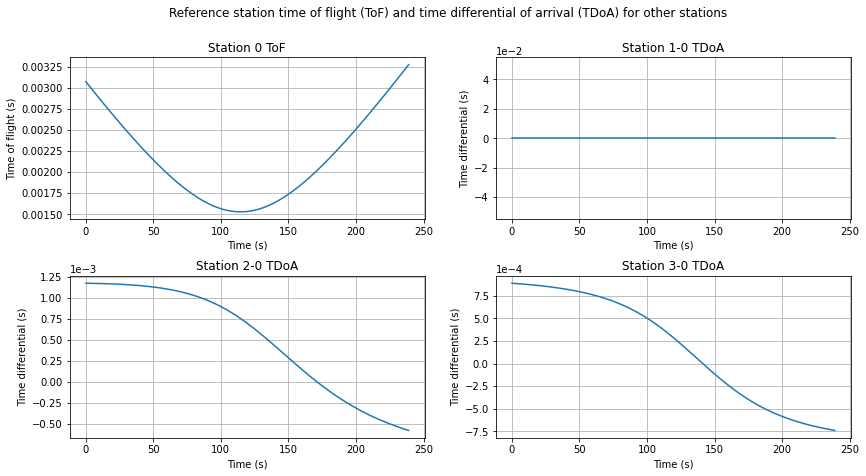

In [1]:
import time
import numpy as np
import argparse
import os

from astropy.time import Time   # Astropy 4.1rc1 is used

from orbdet.utils.utils import *
from orbdet.utils.utils_aux import *
from orbdet.utils.utils_vis import *

from scipy.optimize import fsolve

%matplotlib inline

np.random.seed(100)
np.set_printoptions(precision=4)

x_0, t_sec, x_sat, x_obs, _ = get_example_scenario(id=3, frame='teme')
tdoa, tof = get_tdoa_simulated(x_sat, x_obs)
r, rr = range_range_rate(x_sat, x_obs)

fig = plot_tdoa(tdoa, tof, t_sec)


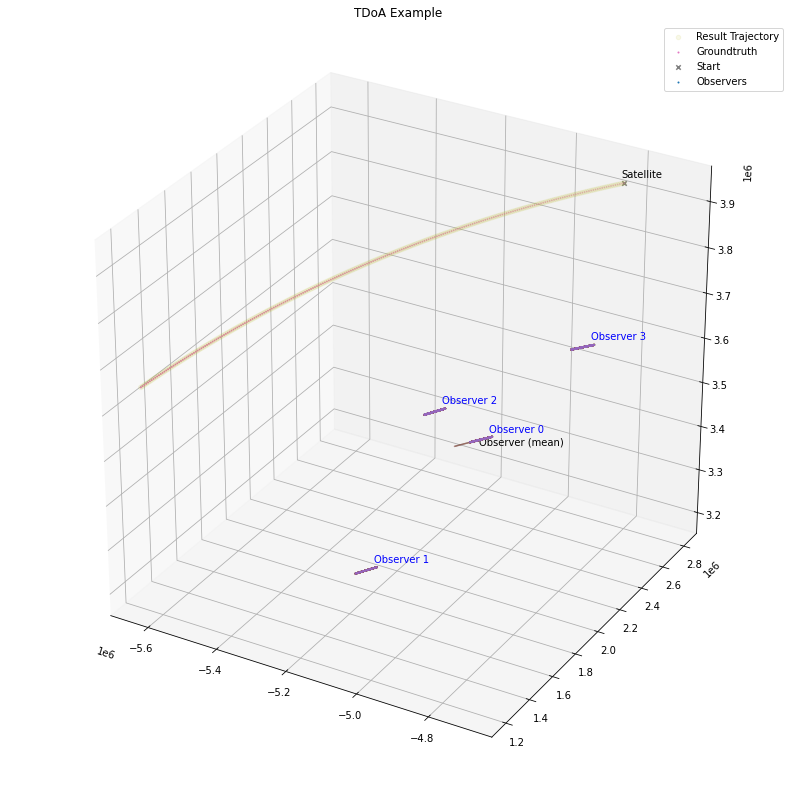

In [2]:
p_sat, tau = solve_tdoa(tdoa, x_obs)

fig = plot_tdoa_results(p_sat, x_obs, x_sat)

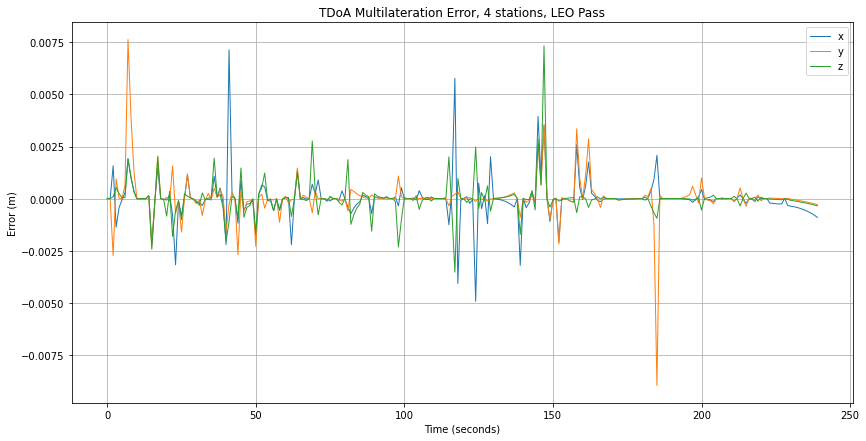

In [3]:
fig = plot_tdoa_errors(p_sat, x_sat)
